<a name = 1></a>
## Loading and Understanding the Data

<a name= 1.1></a>
### Loading the Data

We will use the [🤗 Datasets](https://github.com/huggingface/datasets) library to load the data . This can be easily done with the functions `load_dataset`.  

In [1]:
from datasets import load_dataset

In [2]:
dataset = load_dataset('csv',data_files={'train':'Train.csv',
                                      'validation': 'Dev.csv',
                                      'test': 'Test.csv'})


Using custom data configuration default-cbcc8f9d3e18d149
Reusing dataset csv (C:\Users\debal\.cache\huggingface\datasets\csv\default-cbcc8f9d3e18d149\0.0.0\2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0)


The `dataset` object itself is [`DatasetDict`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasetdict), which contains one key for the training, validation and test set.

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['sent0', 'sent1', 'labels'],
        num_rows: 10000
    })
    validation: Dataset({
        features: ['labels', 'sent0', 'sent1'],
        num_rows: 997
    })
    test: Dataset({
        features: ['labels', 'sent0', 'sent1'],
        num_rows: 1000
    })
})

To access an actual element, you need to select a split first, then give an index:

<a name=1.2></a>
### Understanding the Data

In [4]:
dataset["train"][0]

{'sent0': 'He poured orange juice on his cereal.',
 'sent1': 'He poured milk on his cereal.',
 'labels': 1}

To get a sense of what the data looks like, we will show some examples from the dataset.

In [5]:
import pandas as pd

df = pd.read_csv('Train.csv')
df.head(10)

,sent0,sent1,labels
0,He poured orange juice on his cereal.,He poured milk on his cereal.,1
1,He drinks apple.,He drinks milk.,1
2,Jeff ran a mile today,"Jeff ran 100,000 miles today",0
3,A mosquito stings me,I sting a mosquito,0
4,A niece is a person.,A giraffe is a person.,0
5,A walk-in closet is larger than a normal closet.,A normal closet is larger than a walk-in closet.,0
6,I like to ride my chocolate,I like to ride my bike,1
7,A GIRL WON THE RACE WITH HER FRIEND,A GIRL WON THE RACE WITH HORSE,0
8,he put elephant into the jug,he pour water in to the jug,1
9,A girl plays volleyball,A dog plays volleyball,0


As from above we can see each data point has two sentences and a label telling which is of common sense

<a name=2></a>
## Creating and training Model

<a name=2.1></a>
### Sequence Model


<a name=2.1.1></a>
#### Preparing Data for the Model

We will now prepare data to be fed into the sequence model

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer  # White Space Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences # To get all sequences in same length
import numpy as np

The function written below will help us get data in a format which can be then further used by model as input 

In [7]:
def get_data(df):
    """
    Function to get data to be given to the tensorflow model
    df : Dataset object
    """
    sent_0 = df[:]['sent0']
    sent_1 = df[:]['sent1']
    data = [x+"<SEP>"+y for x,y in zip(sent_0,sent_1)]
    labels = np.array(df[:]['labels'],dtype=np.int32)
    
    return data, labels
    

In [8]:
train_data, train_labels = get_data(dataset['train'])
val_data, val_labels = get_data(dataset['validation'])
test_data, test_labels = get_data(dataset['test'])

We will use keras tokenizer which is a `WhiteSpace Tokenizer` to tokenize out text and use `<UNK>` to replace any out of vocabulary words

In [9]:
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n',oov_token="<UNK>")

In [10]:
tokenizer.fit_on_texts(train_data + val_data)

In [11]:
train_x = tokenizer.texts_to_sequences(train_data)
val_x = tokenizer.texts_to_sequences(val_data)
test_x = tokenizer.texts_to_sequences(test_data)

In [12]:
train_x = pad_sequences(train_x,maxlen=64,padding='post')
val_x = pad_sequences(val_x,maxlen=64,padding='post')
test_x = pad_sequences(test_x,maxlen=64,padding='post')

# Model Creation

The following layers are used in the creation of the model


- [tf.keras.layers.Input()](https://www.tensorflow.org/versions/r2.2/api_docs/python/tf/keras/layers/InputLayer): It is used to instantiate a Keras tensor which is used as an input to the model,in our case the shape ofthe tensor will be (batch_size,64)`tf.keras.layers.Input(shape=(64,))`


- [tf.keras.layers.Embedding()](https://www.tensorflow.org/versions/r2.2/api_docs/python/tf/keras/layers/Embedding): this converts each token to its vector representation. In this case, it is the the size of the vocabulary by the dimension of the model: `tf.keras.layers.Embedding(vocab_size+1, embed_dim)`. `vocab_size` is the number of entries in the given vocabulary. `d_model` is the number of elements in the word embedding.

- [tf.keras.layers.Bidirectional()](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional) We use this so that the output layer can get information from past (backwards) and future (forward) states simultaneously.

- [tf.keras.layers.LSTM()](https://www.tensorflow.org/versions/r2.2/api_docs/python/tf/keras/layers/LSTM): LSTM layer which returns a the output from final cell

- [tf.keras.layers.BatchNormalization()](https://www.tensorflow.org/versions/r2.2/api_docs/python/tf/keras/layers/BatchNormalization):Normalize and scale inputs or activations.

- [tf.keras.layers.Dropout()](https://www.tensorflow.org/versions/r2.2/api_docs/python/tf/keras/layers/Dropout):Applies Dropout to the input.(Prevents from overfitting by deactivating a fraction of neurons from the previous layer)

- [tf.keras.layers.Dense()](https://www.tensorflow.org/versions/r2.2/api_docs/python/tf/keras/layers/Dense): We have used an   output Dense layer with 1 neuron and  [Sigmoid](https://www.tensorflow.org/versions/r2.2/api_docs/python/tf/keras/activations/sigmoid) activation

### LSTM

<img src='Images/LSTM_internal.png'>

In [30]:
def create_model(num_words = len(tokenizer.index_word)+ 1 , embed_dim = 256):
    
    inp = tf.keras.layers.Input((64,))
    l_1 = tf.keras.layers.Embedding(num_words,embed_dim)(inp)
    l_2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(l_1)
    bn_1 = tf.keras.layers.BatchNormalization()(l_2)
    dp_2 = tf.keras.layers.Dropout(0.2)(bn_1)
    out = tf.keras.layers.Dense(1,activation = 'sigmoid')(dp_2)
    
    return tf.keras.models.Model(inp,out)
    

In [31]:
Model = create_model()

In [32]:
Model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 64, 256)           3741184   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                73984     
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 3,815,489
Trainable params: 3,815,361
Non-trainable params: 128
__________________________________________

In [33]:
Model.compile(optimizer=tf.keras.optimizers.Adam(0.001),loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])

In [34]:
Model.fit(x=train_x,y=train_labels,batch_size=128,epochs=5,validation_data=(val_x,val_labels))

Epoch 1/5
79/79 [==============================] - 13s 166ms/step - loss: 0.7156 - accuracy: 0.5029 - val_loss: 0.6933 - val_accuracy: 0.4814
Epoch 2/5
79/79 [==============================] - 11s 144ms/step - loss: 0.5897 - accuracy: 0.6968 - val_loss: 0.6927 - val_accuracy: 0.5186
Epoch 3/5
79/79 [==============================] - 11s 143ms/step - loss: 0.3838 - accuracy: 0.8276 - val_loss: 0.6908 - val_accuracy: 0.5326
Epoch 4/5
79/79 [==============================] - 12s 147ms/step - loss: 0.1955 - accuracy: 0.9252 - val_loss: 0.8196 - val_accuracy: 0.5316
Epoch 5/5
79/79 [==============================] - 11s 146ms/step - loss: 0.1128 - accuracy: 0.9614 - val_loss: 0.9392 - val_accuracy: 0.5426


In [35]:
hist = Model.history.history

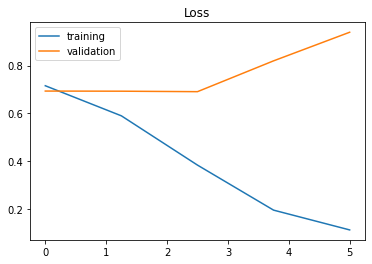

In [36]:
import matplotlib.pyplot as plt

plt.plot(np.linspace(0,5,5),hist['loss'],label='training')
plt.plot(np.linspace(0,5,5),hist['val_loss'], label='validation')
plt.title('Loss')
plt.legend()
plt.show()


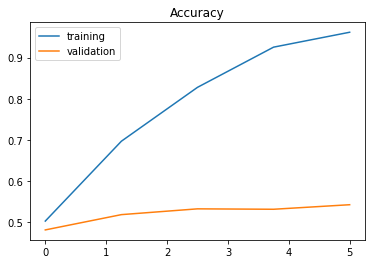

In [37]:
plt.plot(np.linspace(0,5,5),hist['accuracy'],label='training')
plt.plot(np.linspace(0,5,5),hist['val_accuracy'],label='validation')
plt.title("Accuracy")
plt.legend()
plt.show()

From the above graph we can see that this kind of Sequence model tends to overfit on the training data and gives low accuracy on validation set. We will try to tackle this issue using transformer models

## Transformers

## DistilBERT

In [3]:
import transformers

print(transformers.__version__)

4.7.0


In [9]:
task = "wnli"  # We are using this task as it is most similar to our task 
model_checkpoint = "roberta-base"
batch_size = 16

## Loading the dataset

We will use the [🤗 Datasets](https://github.com/huggingface/datasets) library to download the data and get the metric we need to use for evaluation (to compare our model to the benchmark). This can be easily done with the functions `load_dataset` and `load_metric`.  

In [10]:
from datasets import load_metric

In [11]:
metric = load_metric('glue', task)

The metric is an instance of [`datasets.Metric`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Metric):

You can call its `compute` method with your predictions and labels directly and it will return a dictionary with the metric(s) value:

In [12]:
import numpy as np

fake_preds = np.random.randint(0, 2, size=(64,))
fake_labels = np.random.randint(0, 2, size=(64,))
metric.compute(predictions=fake_preds, references=fake_labels)

{'accuracy': 0.609375}

## Preprocessing the data

The first step is to use the BERT tokenizer to first split the word into tokens. Then, we add the special tokens needed for sentence classifications (these are [CLS] at the first position, and [SEP] at the end of the sentence).
<img src= 'Images/bert-distilbert-input-tokenization.png'> 


This is done by a 🤗 Transformers `Tokenizer` which will (as the name indicates) tokenize the inputs (including converting the tokens to their corresponding IDs in the pretrained vocabulary) and put it in a format the model expects, as well as generate the other inputs that model requires.

To do all of this, we instantiate our tokenizer with the `AutoTokenizer.from_pretrained` method, which will ensure:

- we get a tokenizer that corresponds to the model architecture we want to use,
- we download the vocabulary used when pretraining this specific checkpoint.



In [13]:
from transformers import AutoTokenizer
    
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)

We can directly call this tokenizer on one sentence or a pair of sentences:

In [14]:
x = tokenizer("Hello, this one sentence!", "And this sentence goes with it.")

In [15]:
tokenizer.decode(x['input_ids'])

'<s>Hello, this one sentence!</s></s>And this sentence goes with it.</s>'

In [16]:
x

{'input_ids': [0, 31414, 6, 42, 65, 3645, 328, 2, 2, 2409, 42, 3645, 1411, 19, 24, 4, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

Depending on the model you selected, we will see different keys in the dictionary returned by the cell above. 

We can them write the function that will preprocess our samples. We just feed them to the `tokenizer` with the argument `truncation=True`. This will ensure that an input longer that what the model selected can handle will be truncated to the maximum length accepted by the model.(As we are using the base model the maximum length is 512 tokens)

In [17]:
def preprocess_function(examples):
    return tokenizer(examples['sent0'], examples['sent1'], truncation=True)

This function works with one or several examples. In the case of several examples, the tokenizer will return a list of lists for each key:

In [18]:
preprocess_function(dataset['train'][:5])

{'input_ids': [[0, 894, 13414, 8978, 10580, 15, 39, 25629, 4, 2, 2, 894, 13414, 5803, 15, 39, 25629, 4, 2], [0, 894, 6696, 15162, 4, 2, 2, 894, 6696, 5803, 4, 2], [0, 19663, 2075, 10, 7245, 452, 2, 2, 19663, 2075, 727, 6, 151, 1788, 452, 2], [0, 250, 22443, 1690, 1033, 162, 2, 2, 100, 19049, 10, 22443, 2], [0, 250, 21348, 16, 10, 621, 4, 2, 2, 250, 25650, 17459, 16, 10, 621, 4, 2]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

To apply this function on all the sentences (or pairs of sentences) in our dataset, we just use the `map` method of our `dataset` object we created earlier. This will apply the function on all the elements of all the splits in `dataset`, so our training, validation and testing data will be preprocessed in one single command.

In [19]:
encoded_dataset = dataset.map(preprocess_function, batched=True)

In [20]:
encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'sent0', 'sent1'],
        num_rows: 10000
    })
    validation: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'sent0', 'sent1'],
        num_rows: 997
    })
    test: Dataset({
        features: ['attention_mask', 'input_ids', 'labels', 'sent0', 'sent1'],
        num_rows: 1000
    })
})

In [21]:
encoded_dataset.remove_columns_(['sent0','sent1'])

<ipython-input-21-c66dcbf36a6f>:1: FutureWarning: remove_columns_ is deprecated and will be removed in the next major version of datasets. Use DatasetDict.remove_columns instead.
  encoded_dataset.remove_columns_(['sent0','sent1'])


## Fine-tuning the model

Now that our data is ready, we can download the pretrained model and fine-tune it, as these models are trained on a huge corpus so we can use that our advantage to get better representation of words.

We are going to use the `DistilBERT` Model which is smaller version of `BERT` having 66 Million parameters as compared to 350 million parameters of BERT and having simillar accuracy on a large number of tasks.

We will first give the input to the DistilBERT model

<img src = 'Images/bert-model-input-output-1.png'>

Since this is a sentence classification task, we ignore all except the first vector (the one associated with the [CLS] token). The one vector we pass as the input to the Dense layer of the model.

This is how our final model looks like

<img src='Images/Untitled document.jpg'>

In [22]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
num_labels = 2
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

We will now define  the [`TrainingArguments`](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments), which is a class that contains all the attributes to customize the training. It requires one folder name, which will be used to save the checkpoints of the model, and all other arguments are optional:

In [23]:
metric_name = "accuracy"
model_name = model_checkpoint.split("/")[-1]

args = TrainingArguments(
    "model-checkpoint",
    evaluation_strategy = "epoch",  # Evaluation to be done at the end of each epoch
    save_strategy = "epoch",  # Save model after every epoch so after the end of the trainig we can return the best one
    learning_rate=2e-5,     # Learning rate (alpha) for gradient descent
    per_device_train_batch_size=batch_size, # batch_size = 16
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
)

Here we set the evaluation to be done at the end of each epoch, tweak the learning rate, use the `batch_size` defined at the top of the notebook and customize the number of epochs for training, as well as the weight decay. Since the best model might not be the one at the end of training, we ask the `Trainer` to load the best model it saved (according to `metric_name`) at the end of training.


The last thing to define for our `Trainer` is how to compute the metrics from the predictions. We need to define a function for this, which will just use the `metric` we loaded earlier, the only preprocessing we have to do is to take the argmax of our predicted logits

In [24]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

Then we just need to pass all of this along with our datasets to the `Trainer`:

In [25]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

We are passing the tokenizer here again ,because we will use it once last time to make all the samples we gather the same length by applying padding, which requires knowing the model's preferences regarding padding (to the left or right? with which token?). The `tokenizer` has a pad method that will do all of this right for us, and the `Trainer` will use it.

We can now finetune our model by just calling the `train` method:

In [26]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.629700,0.400145,0.832497
2,0.368400,0.390114,0.848546
3,0.274300,0.406477,0.870612
4,0.178800,0.533050,0.856570
5,0.145100,0.591757,0.866600


TrainOutput(global_step=3125, training_loss=0.29438750183105467, metrics={'train_runtime': 1990.0937, 'train_samples_per_second': 25.124, 'train_steps_per_second': 1.57, 'total_flos': 1240959303553920.0, 'train_loss': 0.29438750183105467, 'epoch': 5.0})

We can check with the `evaluate` method that our `Trainer` did reload the best model properly (if it was not the last one):

In [27]:
trainer.evaluate()

{'eval_loss': 0.4064767062664032,
 'eval_accuracy': 0.8706118355065195,
 'eval_runtime': 6.498,
 'eval_samples_per_second': 153.432,
 'eval_steps_per_second': 9.695,
 'epoch': 5.0}

After using the transformer model we see that there is a huge increase in accuracy in validation set in comparison to Sequence Model (increase of `29 %`).

In [20]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import numpy as np
tokenizer = AutoTokenizer.from_pretrained('test-glue/checkpoint-3125')

In [46]:
model = AutoModelForSequenceClassification.from_pretrained('test-glue/checkpoint-3125/')
model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [78]:
def get_pred(sent1,sent2):
        
    tokens = tokenizer(sent1,sent2,return_tensors='pt')
    
    output = model(**tokens)
    
    return np.argmax(output.logits.detach().numpy(),axis=1)

In [79]:
get_pred('He put orange juice on his cereal','He put milk on his cereal')

array([1], dtype=int64)

In [70]:
x = tokenizer(dataset['test'][0:5]['sent0'],dataset['test'][0:5]['sent1'],return_tensors='pt',padding=True)

In [91]:
preds = np.array([])
for i in range(0,len(dataset['test']),batch_size):
    
    tokens = tokenizer(dataset['test'][i:i+batch_size]['sent0'],
                       dataset['test'][i:i+batch_size]['sent1'],return_tensors='pt',padding=True)
    out = model(**tokens)
    out = np.argmax(out.logits.detach().numpy(),axis=1)
    if  not preds.any():
        preds = out
    else:
        preds = np.concatenate((preds,out),axis=0)

#### Accuracy on the Test Set


In [93]:
metric.compute(predictions=preds,references=dataset['test'][:]['labels'])

{'accuracy': 0.812}

In [95]:
df_test = pd.DataFrame({'sent1':dataset['test'][:]['sent0'],
                   'sent2':dataset['test'][:]['sent1'],
                   'Predicted_Label':preds,
                   "True_Label":dataset['test'][:]['labels']})

In [96]:
df_test.head()

,sent1,sent2,Predicted_Label,True_Label
0,He loves to stroll at the park with his bed,He loves to stroll at the park with his dog.,1,1
1,The inverter was able to power the continent.,The inverter was able to power the house,1,1
2,The chef put extra lemons on the pizza.,The chef put extra mushrooms on the pizza.,1,1
3,sugar is used to make coffee sour,sugar is used to make coffee sweet,1,1
4,There are beautiful flowers here and there in ...,There are beautiful planes here and there in t...,0,0
...,...,...,...,...
995,"If it had rained, you would got wet.","If it is a sunny day, you would got wet.",1,0
996,ice hockey is a sport,ice hockey is a financial institution,0,0
997,He put water without a container in the freeze...,He put a watermelon in the freezer for 24 hours,1,1
998,The desert has sand that you can drink.,"The desert is very dry, so bring water when yo...",1,1
